In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.numpy.linalg import slogdet
from jax.scipy.stats import multivariate_normal as mvtn
import matplotlib.pyplot as plt
import numpy as np
from t import t_logpdf
from jax_tqdm import scan_tqdm

/home/jannis/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def rbf_kernel(X1: jnp.ndarray,
                X2: jnp.ndarray,
                lengthscale: float) -> jnp.ndarray:
    sqdist = jnp.sum((X1[:, None, :] - X2[None, :, :]) ** 2, axis=-1)
    return jnp.exp(-0.5 * sqdist / (lengthscale ** 2))

In [3]:
# GP model

def log_pdf(y, X, lengthscale, amplitude, beta):
    return mvtn.logpdf(y, X @ beta, amplitude**2 * rbf_kernel(X, X, lengthscale))

def sample(key, X, lengthscale, amplitude, beta):
    return jax.random.multivariate_normal(key, X @ beta, amplitude**2 * rbf_kernel(X, X, lengthscale))

In [4]:
# we are working with a fixed lengthscale
lengthscale = 1.0

In [5]:
from jax.numpy.linalg import inv

# dof=n-p for right-invariant prior and dof=n for Jeffreys prior
def log_pred(yp, Xp, yo, Xo, dof):
    n_obs = len(yo)
    X = jnp.vstack((Xo, Xp))
    K = rbf_kernel(X, X, lengthscale)
    K_inv = inv(K)
    A = K_inv - K_inv @ X @ inv(X.T @ K_inv @ X) @ X.T @ K_inv
    Aoo, Aop, Apo, App = A[:n_obs, :n_obs], A[:n_obs, n_obs:], A[n_obs:, :n_obs], A[n_obs:, n_obs:]
    App_inv = inv(App)
    Sigma = (yo.T @ (Aoo - Aop @ App_inv @ Apo) @ yo / dof) * App_inv
    mu = - App_inv @ Apo @ yo
    return t_logpdf(yp, mu, Sigma, dof)

# dof=n-p for unbiased and dof=n for MLE
def log_pred_plug_in(yp, Xp, yo, Xo, dof):
    X = jnp.vstack((Xo, Xp))
    y = jnp.hstack((yo, yp))
    K = rbf_kernel(Xo, Xo, lengthscale)
    K_inv = inv(K)
    beta_hat = inv(Xo.T @ K_inv @ Xo) @ Xo.T @ K_inv @ yo
    amp_hat = jnp.sqrt((yo - Xo @ beta_hat).T @ K_inv @ (yo - Xo @ beta_hat) / dof)
    return log_pdf(y, X, lengthscale, amp_hat, beta_hat) - log_pdf(yo, Xo, lengthscale, amp_hat, beta_hat)

In [6]:
# intialize RNG
key_Xot, key_Xpt, key_mc = jax.random.split(jax.random.PRNGKey(0), 3)

In [7]:
# generate data
n, p = 10, 3

Xot = jax.random.uniform(key_Xot, (10, p))[:n, :]
Xot = Xot.at[:, -1].set(1)  # add intercept
Xpt = jax.random.uniform(key_Xpt, (1, p))
Xpt = Xpt.at[:, -1].set(1)  # add intercept

# Extract only the 2D coordinates we want to plot; ignore intercept column
x_obs = np.array(Xot[:, 0])
y_obs = np.array(Xot[:, 1])
x_pred = float(Xpt[0, 0])
y_pred = float(Xpt[0, 1])

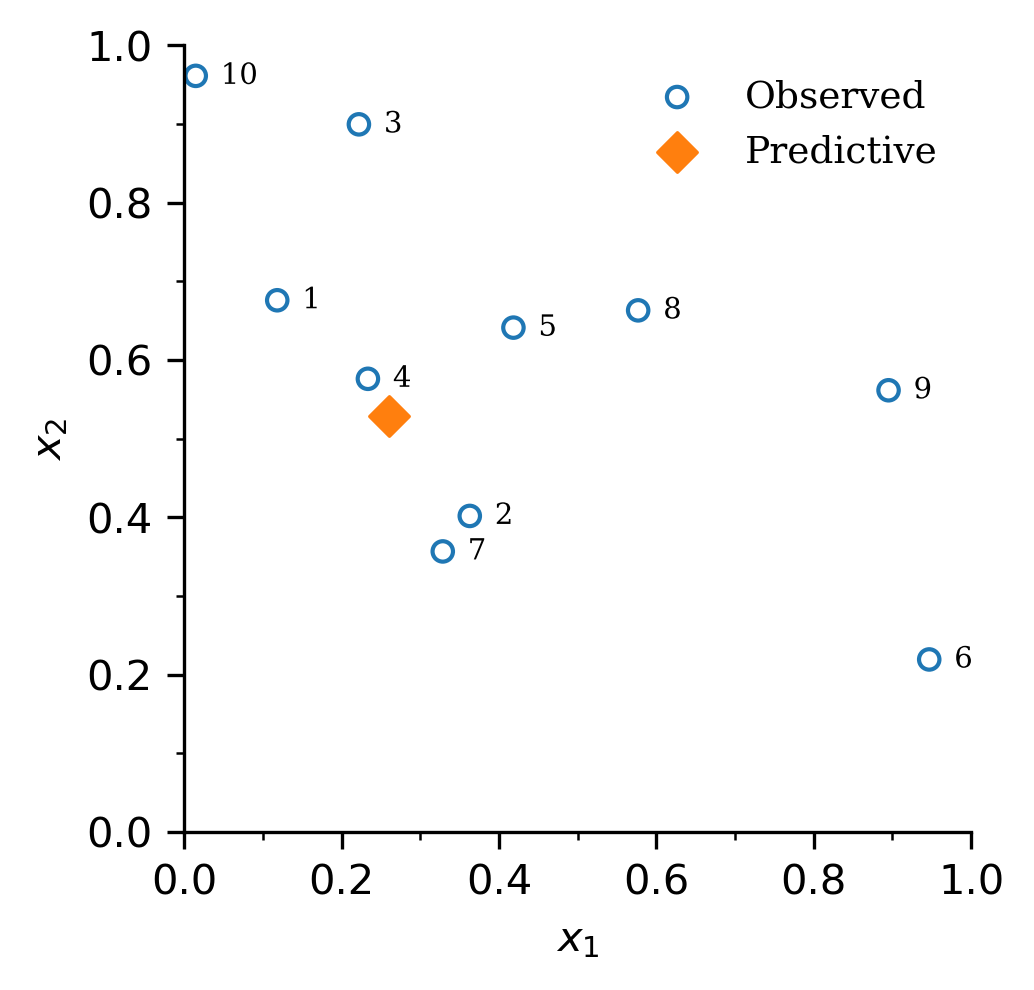

In [8]:
# Visualize (GPT-5 enhanced)

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import AutoMinorLocator

# -----------------------------
# Figure + global styling
# -----------------------------
# Single-column figure size commonly ~3.25–3.5 inches for many journals
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=300)

plt.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "serif",
    "mathtext.fontset": "stix",
})

# -----------------------------
# Plot
# -----------------------------
# Observed points: open circles for print-friendliness
obs = ax.scatter(x_obs, y_obs, s=24, facecolors="none", edgecolors="tab:blue",
                 linewidths=1.0, label="Observed")

# Predictive point: larger diamond marker
pred = ax.scatter([x_pred], [y_pred], s=45, marker="D", color="tab:orange",
                  linewidths=0.8, label="Predictive")

# Index labels with subtle white stroke for legibility
for i in range(n):
    ax.annotate(
        str(i + 1),
        (x_obs[i], y_obs[i]),
        xytext=(6, 0), textcoords="offset points",
        ha="left", va="center",
        fontsize=7,
        path_effects=[pe.withStroke(linewidth=2.0, foreground="white")]
    )

# -----------------------------
# Axes, ticks, spines
# -----------------------------
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Square plot area
ax.set_aspect("equal", adjustable="box")

# Clean up the frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Ticks with minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which="both", direction="out")
ax.tick_params(which="major", length=4)
ax.tick_params(which="minor", length=2)

# Legend outside the axes, no frame
leg = ax.legend(loc="upper right")
leg.set_frame_on(False)

# Tight layout for consistent margins
fig.tight_layout()

fig.savefig("design_points.pdf")
plt.show()


In [9]:
# numerically evaluate predictive procedures against knowing true parameters

# parameters (should not affect the results)
# a, b = jnp.array(2, float), jax.random.uniform(jax.random.PRNGKey(42), (p,))
# a, b = jnp.array(20, float), jnp.array([-7, 5, 2], float)
a, b = jnp.array(1, float), jnp.array([7, 8, 3], float)

@jax.jit
def mc_estimate_risk(key, Xo, Xp, amplitude, beta):
    X = jnp.vstack((Xo, Xp))
    samples = sample(key, X, lengthscale, amplitude, beta)
    yo, yp = samples[:n], samples[n:]
    # true conditional likelihood
    true_pdf = log_pdf(samples, X, lengthscale, amplitude, beta) - log_pdf(yo, Xo, lengthscale, amplitude, beta)
    return jnp.array([
        true_pdf - log_pred(yp, Xp, yo, Xo, dof=n-p),
        true_pdf - log_pred(yp, Xp, yo, Xo, dof=n),
        true_pdf - log_pred_plug_in(yp, Xp, yo, Xo, dof=n-p),
        true_pdf - log_pred_plug_in(yp, Xp, yo, Xo, dof=n)])

samples = 2 ** 16
iters = 2 ** 12

@scan_tqdm(iters)
def step(key, iter):
    key_now, key = jax.random.split(key, 2)
    keys = jax.random.split(key_now, samples)
    results = jax.vmap(mc_estimate_risk, (0, None, None, None, None))(keys, Xot, Xpt, a, b)
    mc_mean = jnp.nanmean(results, axis=0) 
    nans = jnp.sum(jnp.isnan(results), axis=0)
    return key, (iter, mc_mean, nans)
_, (_, mc_means, nans) = jax.lax.scan(step, key_mc, jnp.arange(iters))
print(jnp.mean(mc_means, axis=0), jnp.sqrt(jnp.nanvar(mc_means, axis=0, ddof=1) / iters), jnp.sum(nans, axis=0))

Running for 4,096 iterations: 100%|██████████| 4096/4096 [03:55<00:00, 17.36it/s]


[0.13203049 0.17249193 0.21349069 0.37298507] [3.10375458e-05 4.42682082e-05 7.15021431e-05 1.09875782e-04] [0 0 0 0]


In [10]:
# performance knowing true parameters

def n_entr(var):
    return jnp.log(2 * jnp.pi * jnp.e * var) / 2

base_entropy = n_entr(a**2)
for i in range(n):
    X = jnp.vstack((Xpt, Xot[:(i + 1), :]))
    K = a ** 2 * rbf_kernel(X, X, lengthscale)
    cond_var = K[0, 0] - K[0, 1:] @ inv(K[1:, 1:]) @ K[1:, 0]
    print(i + 1, f"{base_entropy - n_entr(cond_var):.3f}")

1 1.598
2 3.702
3 3.714
4 5.830
5 6.285
6 6.338
7 6.779
8 7.401
9 7.438
10 7.753
